<a href="https://colab.research.google.com/github/AlexeyRogS/cv_course/blob/main/week2/video_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# План занятия:

## Работа с видео в OpenCV
* Чтение видеофайла
* Запись видеофайла

## Задача детекции, классический подход

## OpenCV DNN
* Детекция
* Классификация



---

Установим зависимости для скачивания видео с YouTube:

In [1]:
! pip install pafy -q
! pip install youtube-dl==2020.12.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.9 MB/s eta 0:00:00


In [2]:

import os
import json
from base64 import b64encode

import cv2
import pafy
import numpy as np

from IPython.display import HTML
from google.colab.patches import cv2_imshow

OpenCV позволяет работать с различными источниками видео:
* видео-файлами
* вэб-камерой
* последовательностью изображений
* даже видео-стримами при помощи единого интерфейса

Для этого существует функция [cv2.VideoCapture()](https://docs.opencv.org/4.x/d8/dfe/classcv_1_1VideoCapture.html#ac4107fb146a762454a8a87715d9b7c96).
<br>
Давайте загрузим видео с youtube. Далее будем работать с ним. <br>
Для этого можем воспользоваться библиотекой [pafy](https://pypi.org/project/pafy/).

In [3]:
!mkdir -p input_files

url = 'https://youtu.be/BBJa32lCaaY'
video = pafy.new(url)
print(video)
best = video.getbest()
print(best.resolution, best.extension)

best.download(filepath=f'./input_files/video.{best.extension}')

Title: Rick Rolled (Short Version)
Author: Legacy PNDA
ID: BBJa32lCaaY
Duration: 00:00:11
Rating: None
Views: 1672061
Thumbnail: http://i.ytimg.com/vi/BBJa32lCaaY/default.jpg
640x360 mp4



Проверим, что видео скачалось и все ок.

In [4]:
video_path = f'./input_files/video.{best.extension}'

# Show video
mp4 = open(video_path,'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=640 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

## Чтение видео

Давайте посмотрим, как работать с чтением видео при помощи OpenCV.

Базовый алгоритм работы с классом VideoCapture выглядит следующим образом:
- создаем новый объект video capture
- читаем из него, пока это возможно или пока нам не надоест
- делаем какую-то обработку
- сохраняем или выводим результаты
- освобождаем ресурсы, используемые video capture


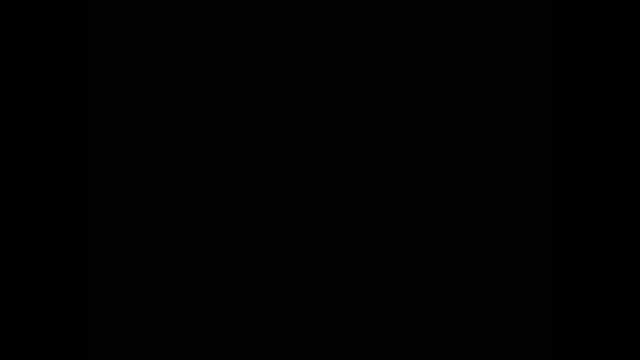

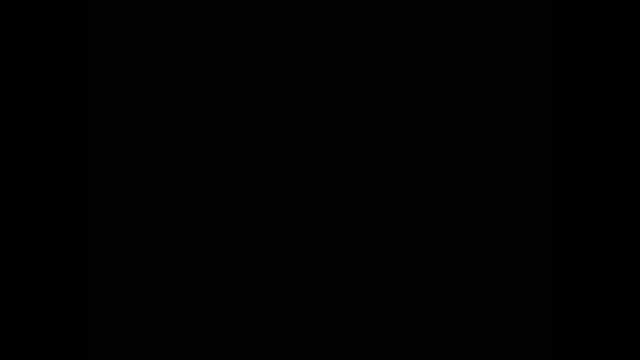

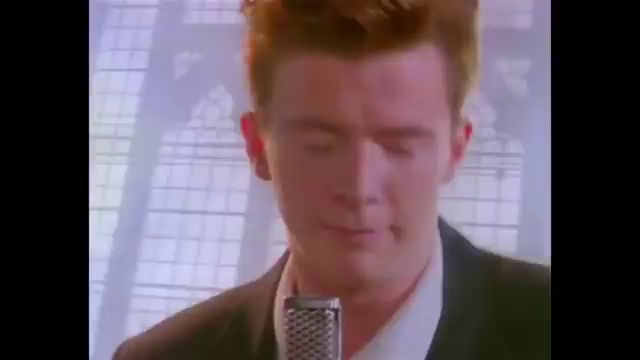

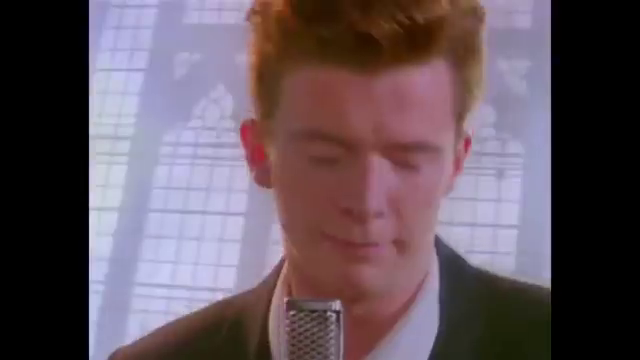

In [5]:
cap = cv2.VideoCapture(f'./input_files/video.{best.extension}')

i = 0
while cap.isOpened():

    # Считываем новый кадр и success code.
    ret, frame = cap.read()

    # cv2.imshow('frame', frame)
    cv2_imshow(frame)

    if i == 3:
      break
    i += 1

cap.release()
cv2.destroyAllWindows()

Ниже приведен базовый скрипт, который мы сможем запустить из консоли и посмотреть на вывод результатов с камеры.


```python
import cv2

# создаем объект VideoCapture.
# Здесь 0 означает использование устройства /dev/video0.
# мы бы могли написать cap = cv2.VideoCapture('/dev/video0')
cap = cv2.VideoCapture(0)

# цикл, пока видео открыто. Можем заменить просто бесконечным циклом.
while cap.isOpened():

    # Считываем новый кадр и success code.
    ret, frame = cap.read()

    # Здесь можно делать обработку изображений

    # отображаем изображение
    cv2.imshow('frame', frame)

    # Важный момент, waitKey позволяет взаимодействовать с клавиатурой.
    # данная строчка позволяет закрыть окно при нажатии клавиши q.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# освобождаем ресурсы
cap.release()
cv2.destroyAllWindows()

```

Здесь может возникнуть вопрос насчет условия `if cv2.waitKey(1) & 0xFF == ord('q')`.

Если вкратце, то это нужно, чтобы независимо от платформы работало ри нажатии на клавишу q.

Подробнее об этом рассказывают на [stackoverflow](https://stackoverflow.com/questions/35372700/whats-0xff-for-in-cv2-waitkey1).

Должно получиться примерно следующее окно.


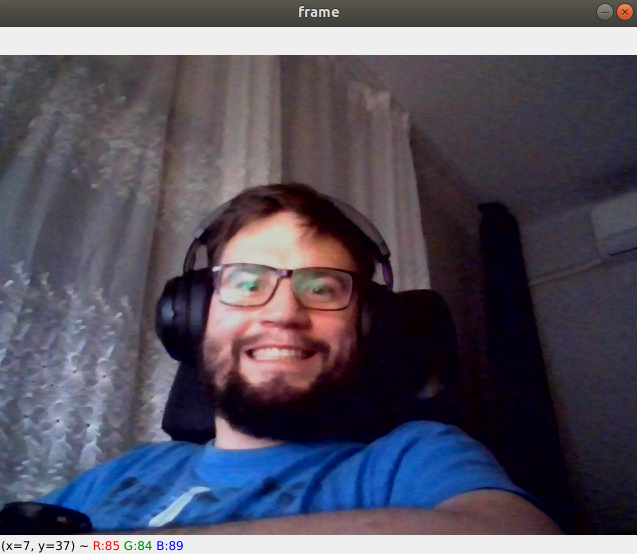

Заметим, что "под капотом" происходит много вещей.




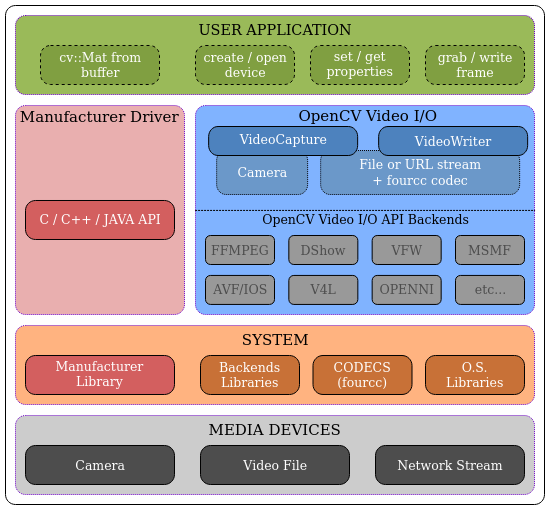

Стоит отметить, что из объекта VideoCapture можно не только вытягивать следующий фрейм. Мы также можем получить информацию о видео. Делается это при помощи метода [get()](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#aa6480e6972ef4c00d74814ec841a2939). Список доступных опций смотрите [здесь](https://docs.opencv.org/3.4/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d).

Например, здесь, мы можем узнать разрешение видео и FPS.

In [6]:
cap = cv2.VideoCapture('./input_files/video.mp4')

print(f'width: {cap.get(cv2.CAP_PROP_FRAME_WIDTH)}')
print(f'height: {cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}')
print(f'FPS: {cap.get(cv2.CAP_PROP_FPS)}')

cap.release()

width: 640.0
height: 360.0
FPS: 25.0


Мы также можем задавать некоторые опции при помощи метода [set()](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a8c6d8c2d37505b5ca61ffd4bb54e9a7c). Например, можем модифицировать предыдущий скрипт, чтобы изменять яркость в вэб камере:

```python
import cv2


cap = cv2.VideoCapture(0)
i = 0
while cap.isOpened():
    i += 1
    cap.set(cv2.CAP_PROP_BRIGHTNESS, i % 255)
    ret, frame = cap.read()
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

```

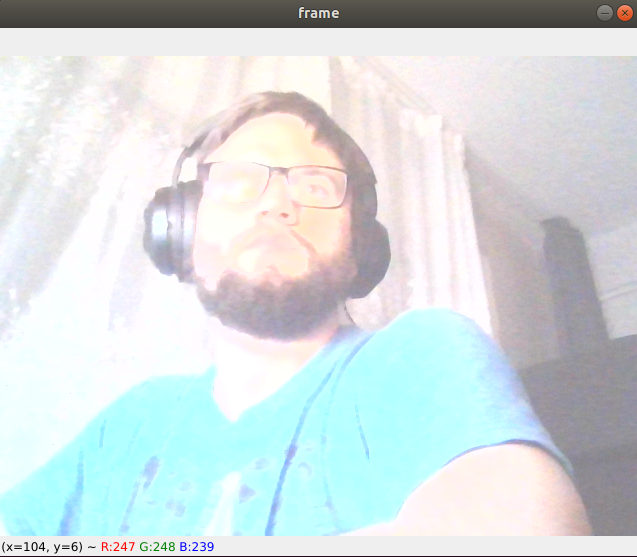

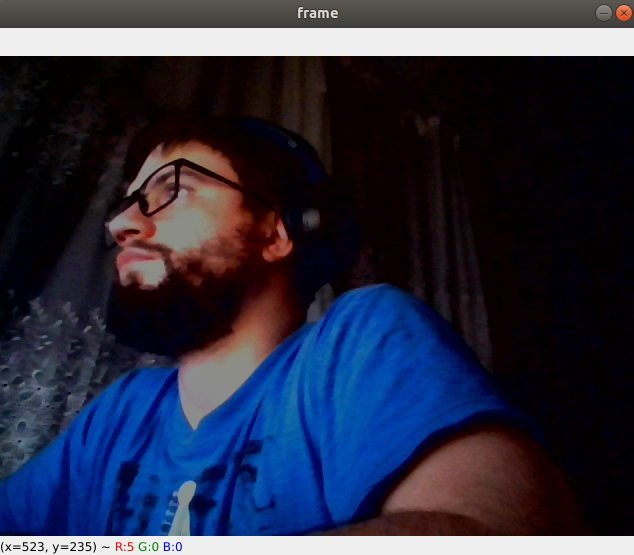

Стоит учесть, что не всякий раз, когда мы делаем get()/set() для какой-то опции мы получим/выставим то значение, которое мы хотели. Это все благодаря тому, что каждая такая операция вовлекает следующую цепочку взаимодействий:

```VideoCapture -> API Backend -> Operating System -> Device Driver -> Device Hardware```,

где на каждом шаге может пойти что-то не так.

Таким образом при разработке приложений необходимо учитывать и то, с какой аппаратурой мы будем взаимодействовать.


## Запись видео

Для записи видео используется класс [VideoWriter()](https://docs.opencv.org/4.5.4/dd/d9e/classcv_1_1VideoWriter.html#ac3478f6257454209fa99249cc03a5c59). "Под капотом" всю работу по кодированию видео исполняет библиотека FFMPEG.

Конструктор принимает следующие аргументы:

- **filename**	Имя выходного файла
- **fourcc**	4-х символьный код для кодека
- **fps**	Выходной фремрейт
- **frameSize**	Разрешение видео
- **isColor**	Записать ли видео цветным или конвертировать в черно-белое

Давайте прочитаем скачанное выше видео, переведем его в черно-белое и сохраним:

In [7]:
!mkdir -p output_files

In [8]:
cap = cv2.VideoCapture('./input_files/video.mp4')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output = cv2.VideoWriter(
    './output_files/video_gray.mp4',
    cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
    fps,
    (width, height),
    0
)

while cap.isOpened():

    ret, frame = cap.read()
    if ret:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        output.write(gray_frame)
    else:
        break
cap.release()
output.release()

In [9]:
video_path = './output_files/video_gray.mp4'
compressed_path = './output_files/video_gray_temp.mp4'
# compress video
os.system(f"ffmpeg -i {video_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=640 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

# Решение задачи детекции без нейронных сетей

В 2001 году появился [алгоритм](https://www.face-rec.org/algorithms/boosting-ensemble/16981346.pdf) Виола-Джонса. <br>
Он основан на [признаках Хаара](https://en.wikipedia.org/wiki/Haar-like_feature). <br>
В OpenCV есть туториал с объяснением, как он [работает](https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html) и как его можно [обучить](https://docs.opencv.org/4.x/dc/d88/tutorial_traincascade.html) на своих данных.

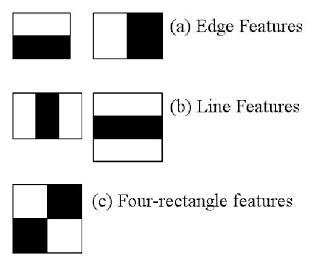

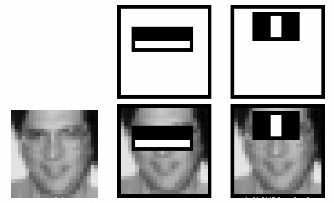

In [10]:
!mkdir -p haarcascades
!wget "https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_frontalface_alt.xml" -q -O ./haarcascades/haarcascade_frontalface_alt.xml
!mkdir -p input_files & wget "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png" -q -O ./input_files/lenna.png

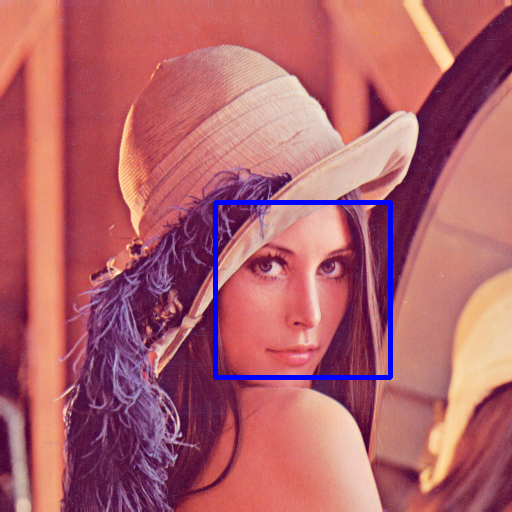

In [11]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread('./input_files/lenna.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(img_gray, 1.1, 5)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)


cv2_imshow(img)

In [12]:
def blur_image(image):
    resized = cv2.resize(image, (10, 10), interpolation=cv2.INTER_LINEAR)
    blurred = cv2.resize(resized, image.shape[:2], interpolation=cv2.INTER_NEAREST)
    return blurred

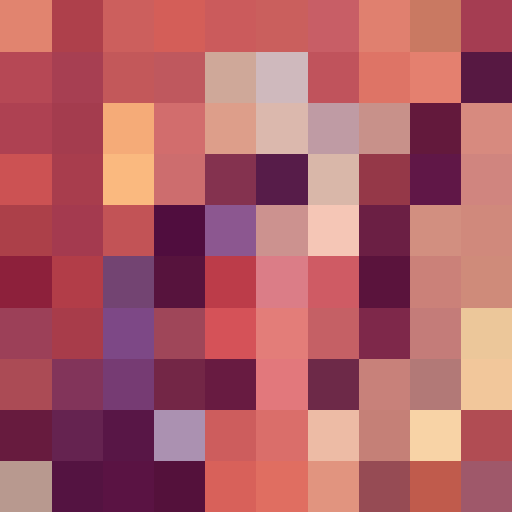

In [13]:
img = cv2.imread('./input_files/lenna.png')
img = blur_image(img)
cv2_imshow(img)

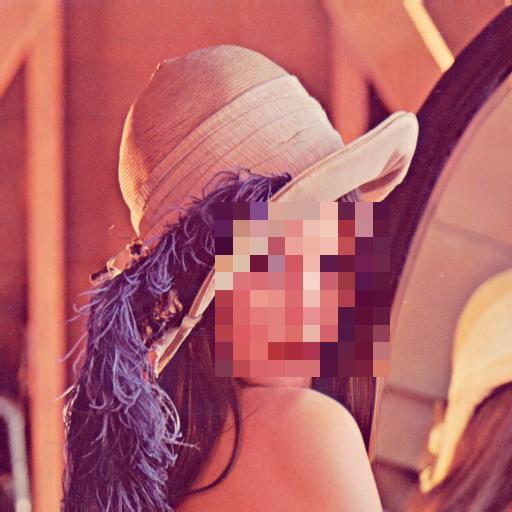

In [14]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread('./input_files/lenna.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(img_gray, 1.1, 5)

for (x, y, w, h) in faces:
    crop = img[y: y + w, x: x + h]
    blurred = blur_image(crop)
    img[y: y + w, x: x + h] = blurred

cv2_imshow(img)

## Задание

Мы выше познакомились с чтением и записью видео, классификатором на основе каскадов Хаара. Давайте теперь заблюрим все лица на скачанном в начале урока видео и сохраним результат.

In [ ]:
OUTPUT_PATH = './output_files/video_blurred.mp4'

cap = #
face_cascade = #


width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output = cv2.VideoWriter(
    OUTPUT_PATH,
    cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
    fps,
    (width, height),
    True
)

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        # Put your code here
        output.write(frame)
    else:
        print('Something gone wrong')
        break


cap.release()
output.release()

In [ ]:
compressed_path = './output_files/video_temp.mp4'
# compress video
os.system(f"ffmpeg -i {OUTPUT_PATH} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=640 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")


## Бонусное задание Shallow Fake:

* Взять изображение с лицом, например (`!wget https://e3.365dm.com/22/05/768x432/skynews-elon-musk_5780923.jpg?20220725073759 -O musk.jpg`)
* Вырезать изображение лица (для этого можно исопльзовать детектор)
* Заменить лица на видео новым лицом

# OpenCV DNN модуль

DNN модуль позволяет загрузить и запустить модели, которые были обучены на других фреймворках.
Данный модуль не позволяет обучать модели. Мы можем только использовать уже обученные.
В данный момент DNN модуль поддерживает следующие фреймворки:
- Caffe
- TensorFlow
- Pytorch
- Darknet
- Models in ONNX format

Для многих операций реализовано использование ускорения при помощи инструкций SSE, AVX, AVX2 и NEON. Также возможно использование технологии CUDA для большинства слоев.

Подробное описание и туториалы можно найти [здесь](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV).


- **Caffe**

 Для того, чтобы загрузить Caffe модель нам нужен файл с весами с расширением .caffemodel и .prototxt файл.
- **TensorFlow**

Тут все похоже на caffe: нам необходим файл с весами с расширением .pb, а также .pbtxt файл.

- **Pytorch**

Модели из pytorch придется конвертировать в ONNX.

- **Darknet**

Для загрузки модели из darknet нам необходимо иметь файл с весами .weights, а также конфигурационный файл с расширением .cfg.


Для загрузки модели используется функция [cv2.dnn.readNet()](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422).

Она ожидает три аргумента:

- model: файл с весами модели

- config: файл с конфигурацией модели

- framework: фреймворк, с которым мы планируем работать


Также есть дополнительные функции, где нам не надо указывать фреймворк.

- readNetFromCaffe()
- readNetFromTensorflow()
- readNetFromTorch()
- readNetFromDarknet()
- readNetFromONNX()



## Задача классификации

Для примера попробуем сконвертировать модель из Pytorch и загрузить ее в DNN модуле. НАстоятельно рекомендую почитать [этот](https://docs.opencv.org/4.x/d7/d9a/pytorch_segm_tutorial_dnn_conversion.html) туториал.

In [15]:
# !pip3 install torch==1.10 torchvision==0.11.0
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 66.4 MB/s eta 0:00:00


In [16]:
import torch
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()

onnx_model_path = "onnx_models"
onnx_model_name = "resnet18.onnx"
os.makedirs(onnx_model_path, exist_ok=True)

full_model_path = os.path.join(onnx_model_path, onnx_model_name)
# generate model input to build the graph
generated_input = torch.randn(1, 3, 224, 224)
# model export into ONNX format
torch.onnx.export(
    resnet18,
    generated_input,
    full_model_path,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [17]:
!wget "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=0.672xw:1.00xh;0.166xw,0&resize=640:*" -q -O 'input_files/dog.jpg'
!wget "https://ichef.bbci.co.uk/news/976/cpsprodpb/12A9B/production/_111434467_gettyimages-1143489763.jpg" -q -O 'input_files/cat.jpg'

In [18]:
!wget "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json" -q -O './onnx_models/imagenet-simple-labels.json'

In [19]:
with open('./onnx_models/imagenet-simple-labels.json') as f:
    labels = json.load(f)

def class_id_to_label(i):
    return labels[i]

In [20]:
opencv_net = cv2.dnn.readNetFromONNX('./onnx_models/resnet18.onnx')

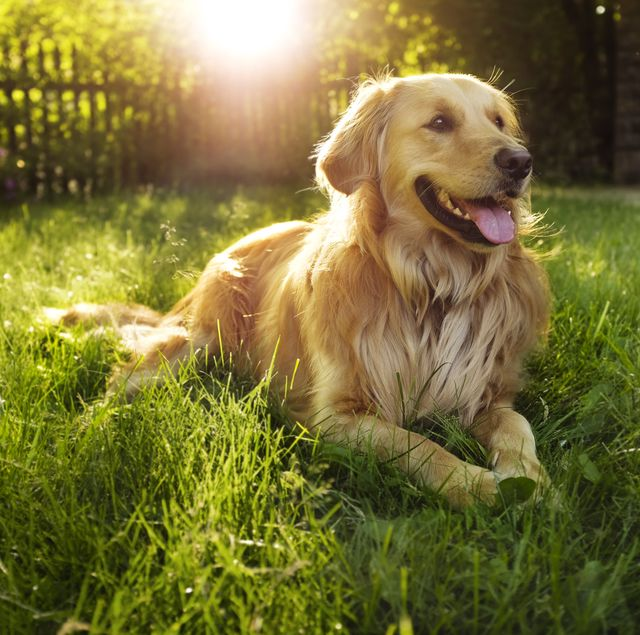

Predicted class id: 207
Predicted class: Golden Retriever


In [21]:
image = cv2.imread('./input_files/dog.jpg')
cv2_imshow(image)
mean = np.array([0.485, 0.456, 0.406]) * 255
scale = 1/255.0
std = [0.229, 0.224, 0.225]
blob = cv2.dnn.blobFromImage(image, scale, (224, 224), mean, swapRB=True, crop=False)
blob[0] /= np.asarray(std, dtype=np.float32).reshape(3, 1, 1)
opencv_net.setInput(blob)

opencv_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
opencv_net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

preds = opencv_net.forward()
pred_index = np.array(preds)[0].argmax()
print(f'Predicted class id: {pred_index}')
print(f'Predicted class: {class_id_to_label(pred_index)}')


## Face Detection with OpenCV DNN

In [22]:
!mkdir -p face_detector
!wget "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel" -q -O ./face_detector/model.caffemodel
!wget "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt" -q -O ./face_detector/model.prototxt

In [23]:
!wget "https://geekhero.ru/wp-content/uploads/2015/04/689848e6-74f6-44a2-9898-0db01eb3b63d-e1428991555635.jpg" -q -O ./input_files/family.jpg

In [24]:
PATH_TO_WEIGHTS = './face_detector/model.caffemodel'
PATH_TO_PROTOTXT = './face_detector/model.prototxt'

net = cv2.dnn.readNetFromCaffe(PATH_TO_PROTOTXT, PATH_TO_WEIGHTS)

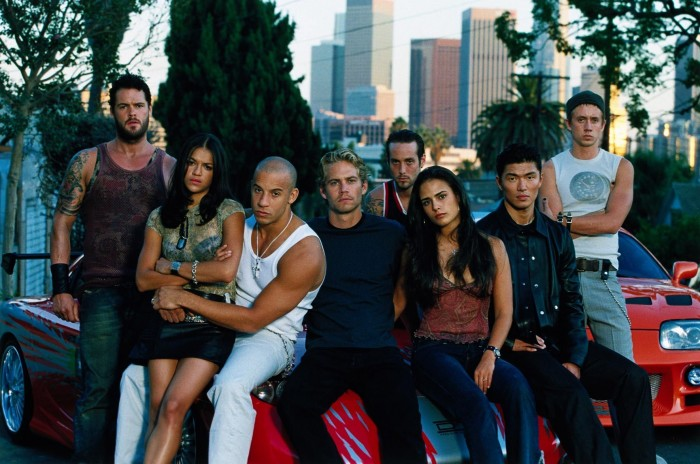

In [25]:
# img = cv2.imread('./input_files/lenna.png')
img = cv2.imread('./input_files/family.jpg')
cv2_imshow(img)

In [26]:
h, w = img.shape[:2]
blob = cv2.dnn.blobFromImage(
            img,
            1.0,
            (300, 300), (104.0, 177.0, 123.0)
        )

net.setInput(blob)
detections = net.forward()

In [27]:
print(detections.shape)


(1, 1, 200, 7)


In [28]:
img_copy = img.copy()
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.3:
        box = (detections[0, 0, i, 3:7] * np.array([w, h, w, h])).astype(np.int32)
        cv2.rectangle(img_copy, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3)

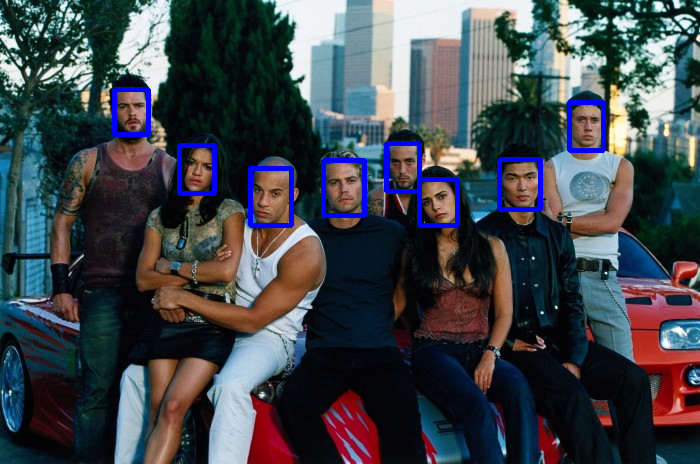

In [29]:
cv2_imshow(img_copy)

## Задание.
Реализуйте алгоритм по блюрингу или замене лиц, но используя уже нейросетевой детектор лиц.